## Desafío - Mecanismos de votación



<br>
<div class="alert alert-block alert-success">

<b>Nombre:</b> María Eugenia Valenzuela- Rene Navarro- Juan Oyarce.

<b>Generación:</b> G2.

<b>Profesor:</b> Gabriel Tamayo L.

</div>


* Para realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad.
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
* Una vez terminado el desafío, comprime la carpeta y sube el .zip a la sección correspondiente.

#### Descripción
Para esta actividad desarrollaremos un ensamble heterogéneo que prediga la popularidad o
inpopularidad de contenido en línea de un sitio web. El archivo csv tiene un total de 39797 registros, donde cada uno representa características del artículo publicado en el sitio web. Cada registro tiene un total de 61 atributos que miden características del texto, cantidad de imágenes, keywords, etc. Los artículos provienen de la publicación K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal.. Los artículos
registrados son de la página web www.mashable.com. 

Más información sobre los atributos se puede encontrar en el archivo OnlineNewsPopularity.names.

### Ejercicio 1 - Preparación del Ambiente de Trabajo
* A continuación se le presenta un código que agrupa las variables por grupos. Cada uno de éstos hace referencia a alguna característica de los registros en la base de datos. Genere una análisis descriptivo de cada uno de los atributos. Puede utilizar la función grid_plot_batch que se encuentra en el archivo helpers.py.

```python
# las etiquetas de las columnas presentan un espacio extra, con ésto lo podemos eliminar
df.columns = [i.replace(' ', '') for i in df.columns]
# eliminamos el string de url que no sirve para el análisis
df = df.loc[:, 'n_tokens_title':'shares']
# generamos el conjunto de variables
qnty = df.filter(regex='^n_', axis=1)
channel = df.filter(regex='^data_', axis=1)
days = df.filter(regex=re.compile("weekday|weekend"), axis=1)
sentiments = df.filter(regex=re.compile("negative|positive|subjectivity"),axis=1)
lda = df.filter(regex='^LDA_\d', axis=1)
keywords = df.filter(regex='^kw_', axis=1)

```

* Describa el comportamiento de las variables.
* Dada la naturaleza de los atributos, es probable que algunas mediciones estén correlacionadas entre sí. Para ello, genere un diagnóstico previo de multicolinealidad utilizando la función identify_high_correlations que se encuentra en el archivo helpers.py . Para todos aquellos atributos que tengan una correlación de .8, reporte sus nombres.
* Antes de generar los conjuntos de entrenamiento y validación, preprocese los datos con los siguientes pasos:
    * Recodifique la variable shares en una variable binaria que identifique como 1 todos los registros con más de 1400 "compartir" y 0 de lo contrario. Para evitar multicolinealidad, elimine la variable shares posteriormente.
    * Elimine todas las variables que presentaban una correlación mayor a .8. Este paso es para evitar la multicolinealidad de los atributos.
    * Genere un análisis de Componentes Principales para extraer las principales 30 dimensiones. Guarde estas dimensiones en un nuevo objeto.
    
<div class="alert alert-block alert-warning">
<b>Tips:</b> 
    
   - La función identify_high_correlations retorna un dataframe con las columnas con mayor correlación. Debe eliminar solo una de las variables correlacionadas, utilice para esto los nombres de variables del campo 'variable' del df retornado.

</div>

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error,r2_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import re
from helpers import grid_plot_batch as gpb
from helpers import identify_high_correlations as ihc
import operator
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display

In [2]:
df = pd.read_csv('OnlineNewsPopularity.csv') 
df.shape 

(39644, 61)

In [3]:
# las etiquetas de las columnas presentan un espacio extra, con ésto lo podemos eliminar
df.columns = [i.replace(' ', '') for i in df.columns]

In [4]:
# eliminamos el string de url que no sirve para el análisis
df = df.loc[:, 'n_tokens_title':'shares']

In [5]:

# generamos el conjunto de variables
qnty = df.filter(regex='^n_', axis=1)
channel = df.filter(regex='^data_', axis=1)
days = df.filter(regex=re.compile("weekday|weekend"), axis=1)
sentiments = df.filter(regex=re.compile("negative|positive|subjectivity"),axis=1)
lda = df.filter(regex='^LDA_\d', axis=1)
keywords = df.filter(regex='^kw_', axis=1)

In [6]:
keywords.shape[1]

9

### Gráficos de las variables

In [7]:
# Función modificada  para graficar
def grid_plot_batch(df, cols):
   # calcular un aproximado a la cantidad de filas
    rows = np.ceil(df.shape[1] / cols)
    plt.figure(figsize=(20, 20))
    for index, (colname, serie) in enumerate(df.iteritems()):
        fig = plt.subplot(6, 3, index+1)
        l_1 = plt.axvline(serie.mean(), color='Tomato')
        l_2 = plt.axvline(serie.mean(), color='Grey')
        if serie.dtype == float:
            sns.distplot(serie)
        if serie.dtype == int:
            sns.countplot(serie)
        fig.legend([l_1, l_2],['Mean', 'Median'],
                 loc='center right',   # Position of legend
                 borderaxespad=0.1,    # Small spacing around legend box
                )
        plt.tight_layout()

Gráficos de la variable qnty


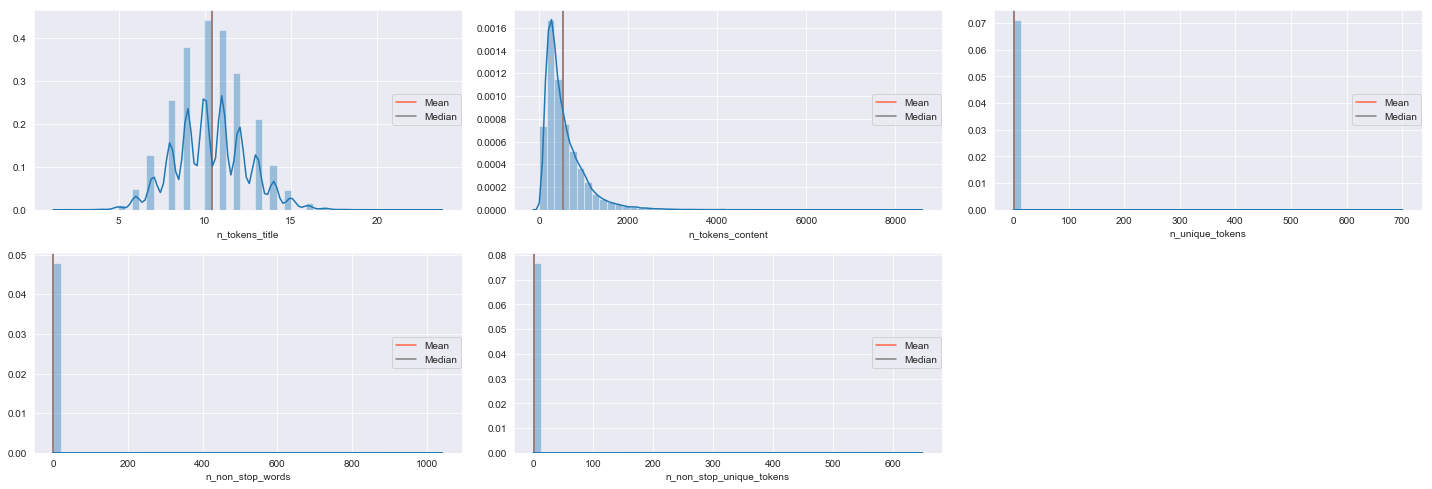

In [8]:
print('Gráficos de la variable qnty')
grid_plot_batch(qnty, qnty.shape[1])

- Se aprecia que los atributos de la variable cantidad de tokens, presentan distribuciones de datos no semejantes a la normal, salvo el primer gráfico del número de tokens por títulos, el resto presenta sesgos importantes 

Gráficos de la variable channel


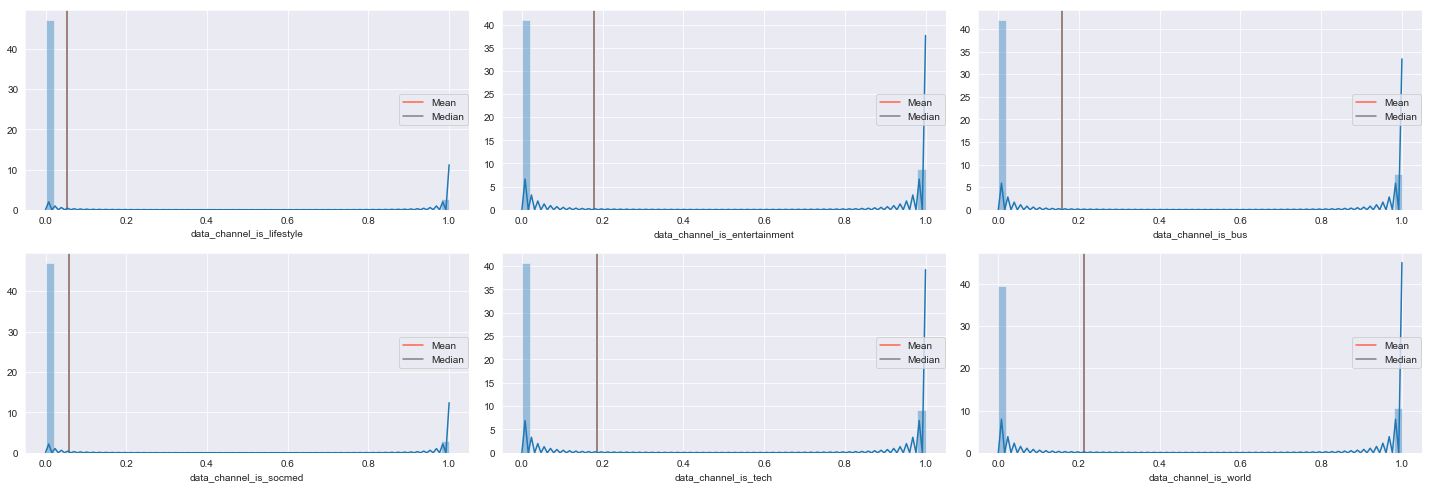

In [9]:
print('Gráficos de la variable channel')
grid_plot_batch(channel, channel.shape[1])

- Los canales presentan valores oscilantes que se agrupan al principio y al final de las distribuciones

Gráficos de la variable days


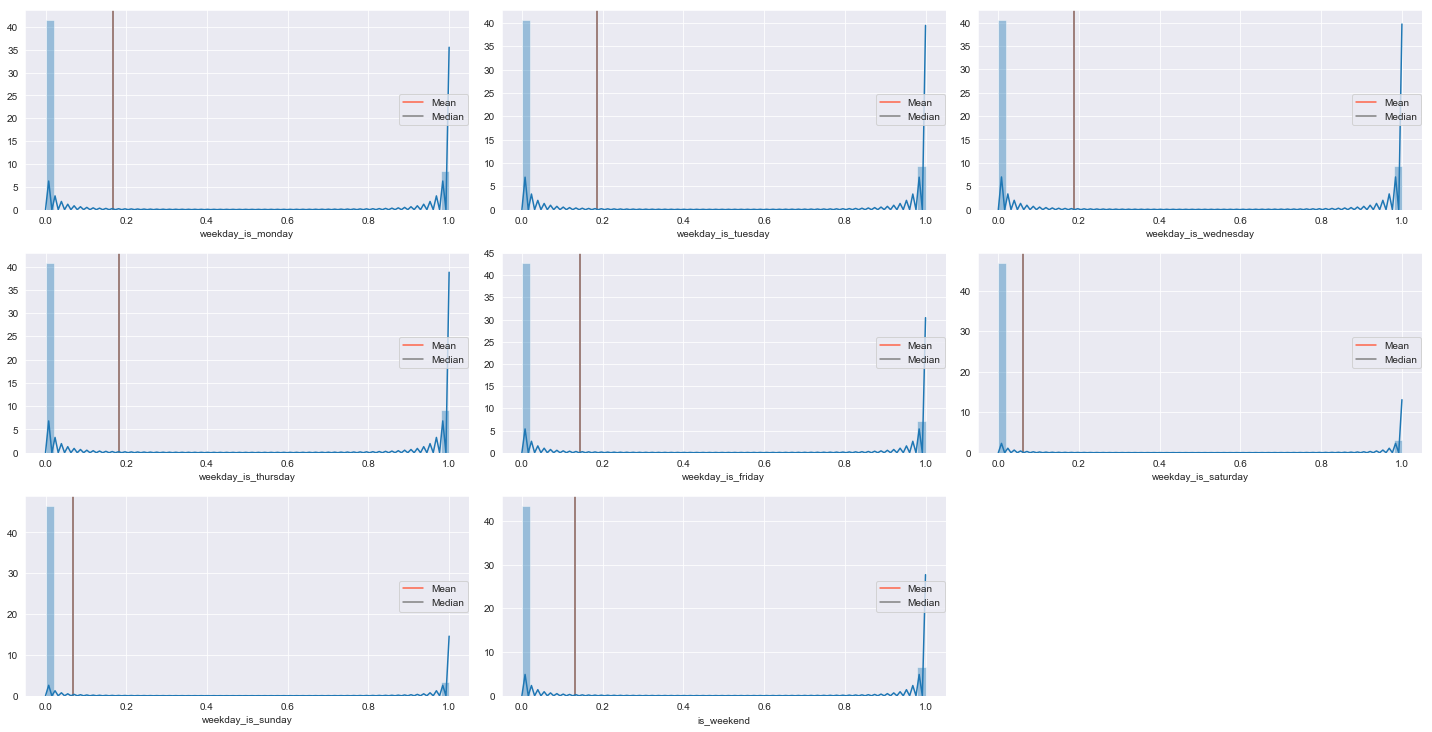

In [10]:
print('Gráficos de la variable days')
grid_plot_batch(days, days.shape[1])

 - La variable days presenta valores oscilantes que se agrupan al principio y al final de las distribuciones

Gráficos de la variable sentiments


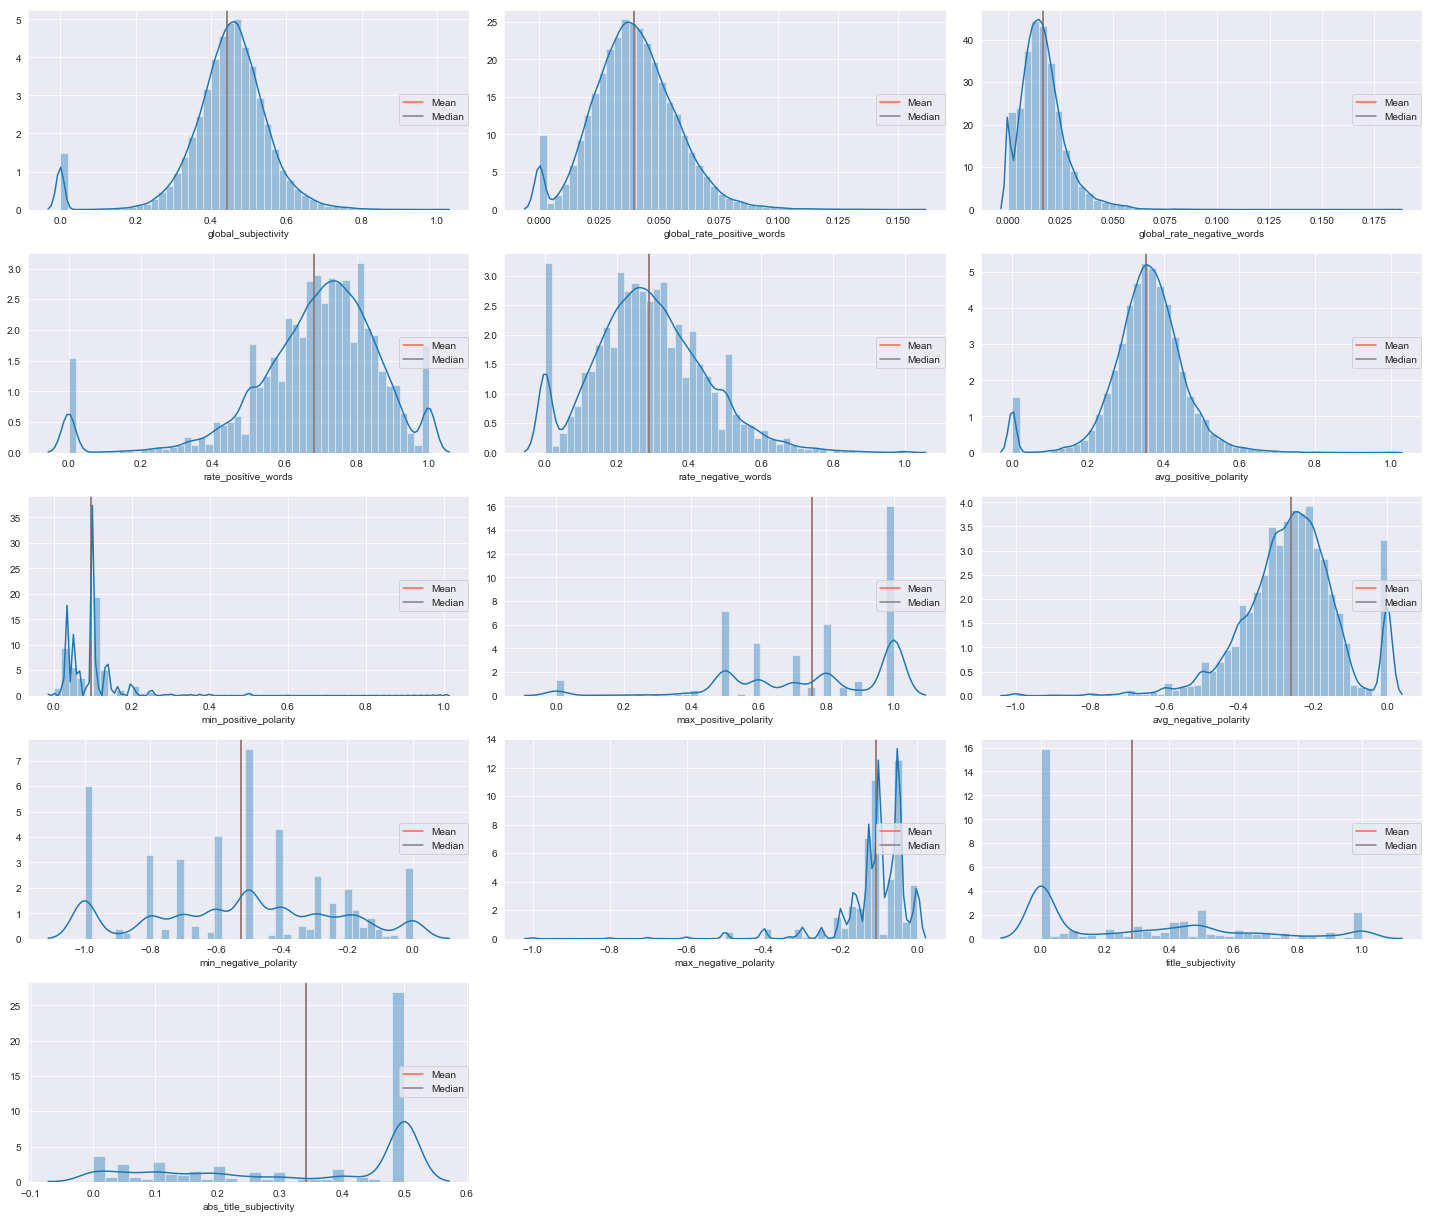

In [11]:
print('Gráficos de la variable sentiments')
grid_plot_batch(sentiments, sentiments.shape[1]) 

- La variable sentiments presenta atributos con comportamientos disimiles, algunos como subjetividad global se asemejan a una distribución normal, el resto de los atributos presenta sesgos en valores altos o bajos de las distribuciones.

Gráficos de la variable lda


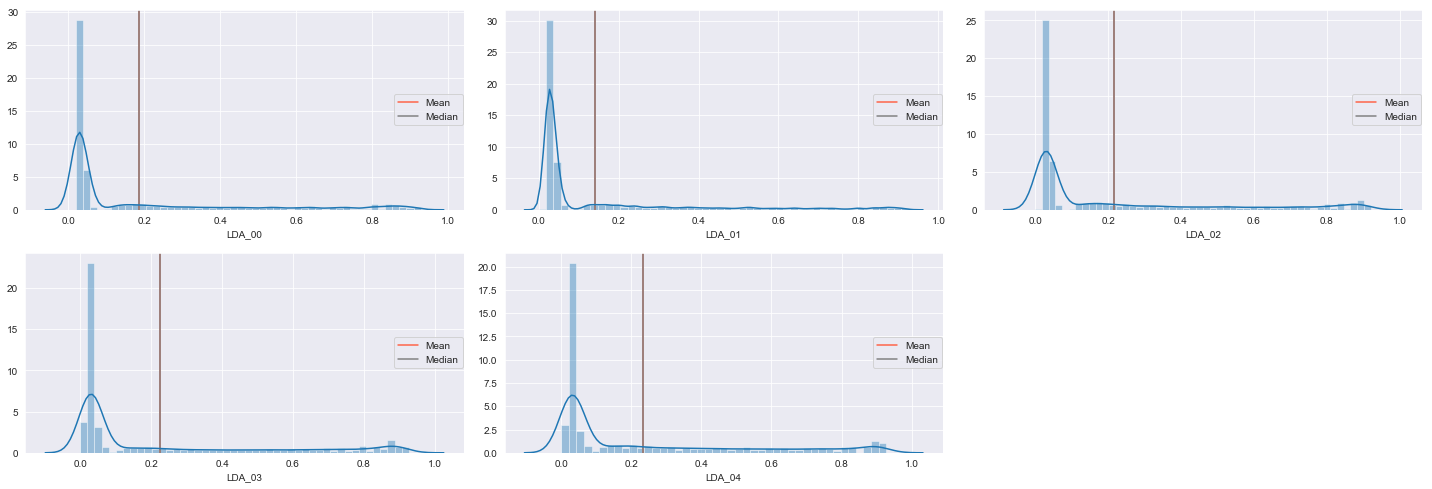

In [12]:
print('Gráficos de la variable lda')
grid_plot_batch(lda, lda.shape[1]) 

- La variable LDA presenta atributos con comportamientos disimiles, que exhiben sesgos en valores altos o bajos de las distribuciones.

Gráficos de la variable keywords


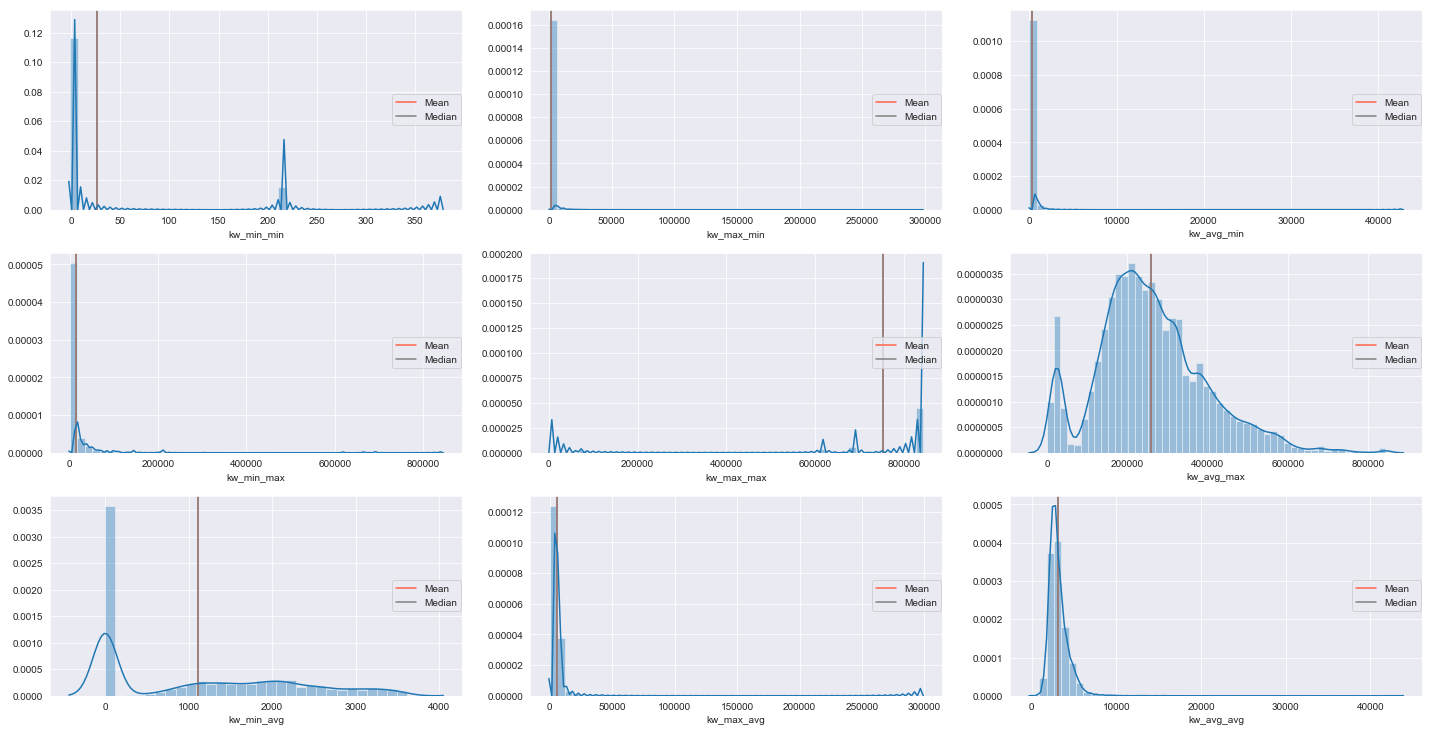

In [13]:
print('Gráficos de la variable keywords')
grid_plot_batch(keywords, keywords.shape[1]) 

- La variable Keywords presenta atributos con comportamientos disimiles, que exhiben sesgos en valores altos o bajos de las distribuciones, el promedio de palabras claves máximas es el único atributo que se asemeja más a una distribución normal.





In [14]:
# Preparación del dataset
var_drop = list(ihc(df).variable) # Lista de variables colíneales (.8) a eliminar con la función  identify_high_correlations
df_2 = df.drop(var_drop, axis=1)
df_2['shares'] = np.where(df_2['shares'] >= 1400, 1, 0)
display (df_2.head())
display(df_2['shares'].value_counts('%'))

,n_tokens_title,n_tokens_content,n_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,12.0,219.0,0.663594,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,0
1,9.0,255.0,0.604743,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,0
2,9.0,211.0,0.575130,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1
3,9.0,531.0,0.503788,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,0
4,13.0,1072.0,0.415646,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,0


1    0.533599
0    0.466401
Name: shares, dtype: float64

In [15]:
# Reducción de dimensionalidad y extracción de los 30 componentes principales con PCA
from sklearn.decomposition import PCA
X = df_2.drop('shares', axis=1) # Eliminar el vector objetivo para evitar error de colinealidad
pca = PCA(n_components=30)
pca.fit(X) 

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [16]:
# Generación de un dataframe nuevo con los componentes principales extraídos
df_3 = pd.DataFrame(pca.transform(X))

In [17]:
# Generación sub set de entrenamiento 
X_train, X_test, y_train, y_test = train_test_split(df_3.loc[:, 0:29],
df_2['shares'], test_size=.33, random_state=1986)

### Ejercicio 2 - Evaluación de modelos individuales
* A continuación generará una serie de modelos que se incorporarán posteriormente al comité de votación. Para ello, se solicita que:
    * Importe los módulos correctamente.
    * Para cada uno de ellos, genere un reporte en las métricas de desempeño respecto a Precision , Recall , F1 . Puede hacer uso de la función plot_classification_report disponible en el archivo helpers.py .
    * Comente el desempeño general de cada uno
* La lista de modelos es la siguiente. Cabe destacar que la mayoría de éstos corresponden a implementaciones vanilla, salvo que se indique lo contrario:
    * Regresión Logística.
    * Algoritmo de KMedias con n_cluster=2.
    * Árbol de Clasificación con un max_depth=1 .
    * Árbol de Clasificación con un max_depth=4 .
    
<div class="alert alert-block alert-warning">
<b>Tips:</b> 
    
   - Es posible que la función plot_classfication_report no funcione si la versión de sklearn no es compatible, si ese es el caso se le recomienda utilizar/adaptar el siguiente código:
   
   
```python
def plot_classification_report_v2(y_true, y_hat):
    # generate classification_report like dict
    report_classification = classification_report(y_true, y_hat,output_dict=True)
    # transform to df
    report = pd.DataFrame(report_classification).T.reset_index()
    report = report.loc[report["index"].isin(np.unique(y_true).astype(str))]
    # rename columns
    report.rename(columns={"index": "idx", 
                           "precision": "prec",
                          "recall": "rec",
                          "f1-score": "f1",
                          "support": "n"}, inplace=True)
    # preserve class labels
    class_labels = report.pop('idx').apply(int)
    # separate values
    class_report = report.applymap(float)
    colors = ['dodgerblue', 'tomato', 'purple', 'orange']
    
    for i in class_labels:
        plt.plot(class_report['prec'][i], [1], marker='*', color=colors[i],markersize=12)
        plt.plot(class_report['rec'][i], [2], marker='*', color=colors[i],markersize=12)
        plt.plot(class_report['f1'][i], [3], marker='*',
                 color=colors[i], 
                 label=f'Class: {i}',
                 markersize=12)
    plt.yticks([1.0, 2.0, 3.0], ['Precision', 'Recall', 'f1-Score'])
    plt.axvline(.5, label='.5 Boundary', linestyle='--')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlim((0.1, 1.0))
    plt.tight_layout()
```

</div>

In [18]:
# importación de módulos de modelos
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans


In [19]:
#función para generar gráficos con reportes de clasificación
def plot_classification_report(y_true, y_hat):
    """
    plot_classification_report: Genera una visualización de los puntajes reportados con la función `sklearn.metrics.classification_report`.

    Parámetros de ingreso:
        - y_true: Un vector objetivo de validación.
        - y_hat: Un vector objetivo estimado en función a la matriz de atributos de validación y un modelo entrenado.

    Retorno:
        - Un gráfico generado con matplotlib.pyplot

    """
    # process string and store in a list
    report = classification_report(y_true, y_hat).split()
    # keep values
    report = [i for i in report if i not in ['precision', 'recall', 'f1-score', 'support', 'avg']]
    # transfer to a DataFrame
    report = pd.DataFrame(np.array(report).reshape(len(report) // 5, 5))
    # asign columns labels
    report.columns = ['idx', 'prec', 'rec', 'f1', 'n']
    # preserve class labels
    class_labels = report.iloc[:np.unique(y_true).shape[0]].pop('idx').apply(int)
    # separate values
    class_report = report.iloc[:np.unique(y_true).shape[0], 1:4]
    # convert from str to float
    class_report = class_report.applymap(float)
    # convert to float average report
    average_report = report.iloc[-1, 1: 4].apply(float)

    colors = ['dodgerblue', 'tomato', 'purple', 'orange']

    for i in class_labels:
        
        
        plt.plot(class_report['prec'][i], [1], marker='x', color=colors[i])
        plt.plot(class_report['rec'][i], [2], marker='x', color=colors[i])
        plt.plot(class_report['f1'][i], [3], marker='x',color=colors[i], label=f'Class: {i}')

    plt.scatter(average_report, [1, 2, 3], marker='o', color='forestgreen', label='Avg')
    plt.yticks([1.0, 2.0, 3.0], ['Precision', 'Recall', 'f1-Score'])
    

In [20]:
# definimos el comité de clasificadores en una lista de tuplas
estimators = [
('Logistic Regression',LogisticRegression(random_state=1986)),
('Decision Tree Classifier',DecisionTreeClassifier(max_depth=1, random_state=1986)),
('Decision Tree Classifier_2', DecisionTreeClassifier(max_depth=4,random_state=1986)),
('Kmeans', KMeans(n_clusters=2, random_state=1986)),
]

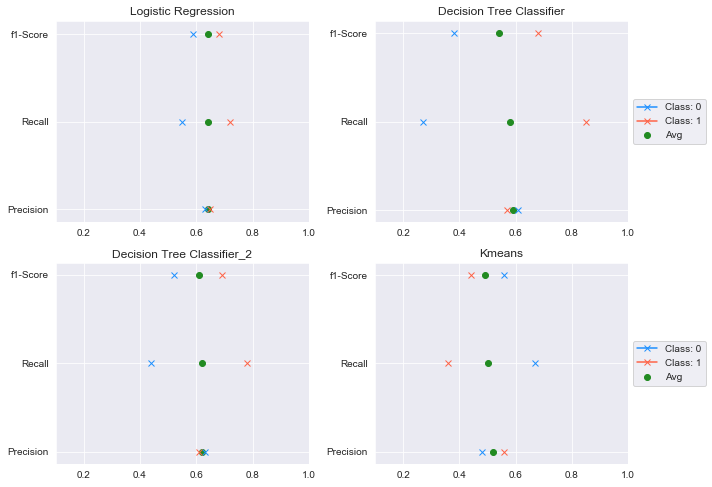

In [21]:
# Iteración de la función de reportes de clasificación con gráficos

plt.figure(figsize=(10, 10))
for index, value in enumerate(estimators):
    plt.subplot(3, 2, index + 1)
    
    plt.title(value[0])
    class_pred = value[1].fit(X_train, y_train).predict(X_test)
    plot_classification_report(y_test, class_pred)
    plt.xlim((0.1, 1.0))
    if (index + 1) % 2 == 0:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    

- La figura muestra el desempeño individual de los modelos de clasificación, se aprecia que la regresión logística y el árbol de clasificación_2 tienen los mejores desempeños con métricas promedio de f1, recall y precisión sobre 0.6, el algoritmo de peor desempeño y más dispersión es Kmeans.

### Ejercicio 3 - Entrenamiento de Comité
* Entrene el comité de clasificadores sin modificar el esquema de votación.
* Reporte el desempeño a nivel de cada clase para cada métrica.

In [22]:
# Instaciación del cómite
voting_classifier = VotingClassifier(estimators).fit(X_train, y_train)


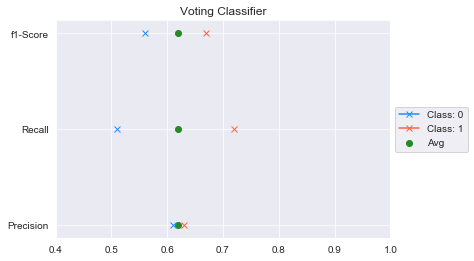

In [23]:
# Reporte del cómite 

plot_classification_report(y_test,voting_classifier.fit(X_train,y_train).predict(X_test))
plt.xlim((0.4, 1.0))
plt.title('Voting Classifier');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

- El cómite exhibe valores ligeramente superiores a 0.6, donde la precisión mejora bastante, pero la sensibilidad muestra una dispersión entre la clase 0 y 1, no obstante las clases se encuentran balanceadas casí al 50 %, donde la clase 0 tiene una sensibilidad menor que la clase 1 (los post populares).  

### Ejercicio 4 - Calibración de Comité con Ponderadores
* En base al comportamiento de los clasificadores individuales del ensamble, proponga dos esquemas de ponderación para mejorar el desempeño del modelo.
* Reporte el desempeño del mejor ensamble heterogéneo.

In [ ]:
# Función auxiliar para evaluar el comité con las estrategias de ponderación

def weighting_schedule(voting_ensemble, X_train, X_test, y_train, y_test, weights_dict, plot_scheme=True, plot_performance=True):
    """TODO: Docstring for weighting_schedule.

    :voting_ensemble: TODO
    :X_train: TODO
    :X_test: TODO
    :y_train: TODO
    :y_test: TODO
    :weights_dict: TODO
    :plot_scheme: TODO
    :plot_performance: TODO
    :returns: TODO

    """

    def weight_scheme():
        """TODO: Docstring for weight_scheme.
        :returns: TODO

        """
        weights = pd.DataFrame(weights_dict)
        weights['model'] = [i[0] for i in voting_ensemble.estimators]
        weights = weights.set_index('model')
        sns.heatmap(weights, annot=True, cmap='Blues', cbar=False)
        plt.title('Esquema de Ponderación')

    def weight_performance():
        """TODO: Docstring for weight_performance.
        :returns: TODO

        """

        n_scheme = len(weights_dict)
        f1_metrics, accuracy = [], []
        f1_metrics_train, accuracy_train = [], []

        for i in weights_dict:
            model = voting_ensemble.set_params(weights=weights_dict[i]).fit(X_train, y_train)
            tmp_model_yhat = model.predict(X_test)
            tmp_model_yhat_train = model.predict(X_train)
            f1_metrics.append(f1_score(y_test, tmp_model_yhat).round(3))
            f1_metrics_train.append(f1_score(y_train, tmp_model_yhat_train).round(3))
            accuracy.append(accuracy_score(y_test, tmp_model_yhat).round(3))
            accuracy_train.append(accuracy_score(y_train, tmp_model_yhat_train).round(3))
        plt.plot(range(n_scheme), accuracy, 'o', color='tomato', alpha=.5, label='Exactitud-Test')
        plt.plot(range(n_scheme), f1_metrics, 'x', color='tomato', alpha=.5, label='F1-Test')
        plt.plot(range(n_scheme), accuracy_train, 'o', color='dodgerblue', alpha=.5, label='Exactitud-Train')
        plt.plot(range(n_scheme), f1_metrics_train, 'x', color='dodgerblue', alpha=.5, label='F1-Train')
        plt.xticks(ticks=range(n_scheme), labels=list(weights_dict.keys()), rotation=90)
        plt.title('Desempeño en Train/Test')
        plt.legend(loc='center left', bbox_to_anchor=(1, .5))


    if plot_scheme is True and plot_performance is True:
        plt.subplot(1, 2, 1)
        weight_scheme()
        plt.subplot(1, 2, 2)
        weight_performance()

    else:
        if plot_scheme is True:
            weight_scheme()
        elif plot_performance is True:
            weight_performance()

In [ ]:
# definimos un diccionario con los esquemas de ponderación, en esté caso 3 un escenario, donde tengan la misma probabilidad para 
# sea nuestro control y un escenario
weights_hyperparams = {'Equiprobabilidad': [.25, .25, .25, .25],
                       'AumentoDTC, DTC_2 y LR/Anulación KMeans': [.30, .35, .35, .0],
                       'AumentoLR, DTC_2/Disminucion Kmeans y DTC': [.40, .10, .40, .10],
                       'Aumento DTC_2 y LR/Anulación Kmeans y DTC':[.50, .0, .50, .0]}


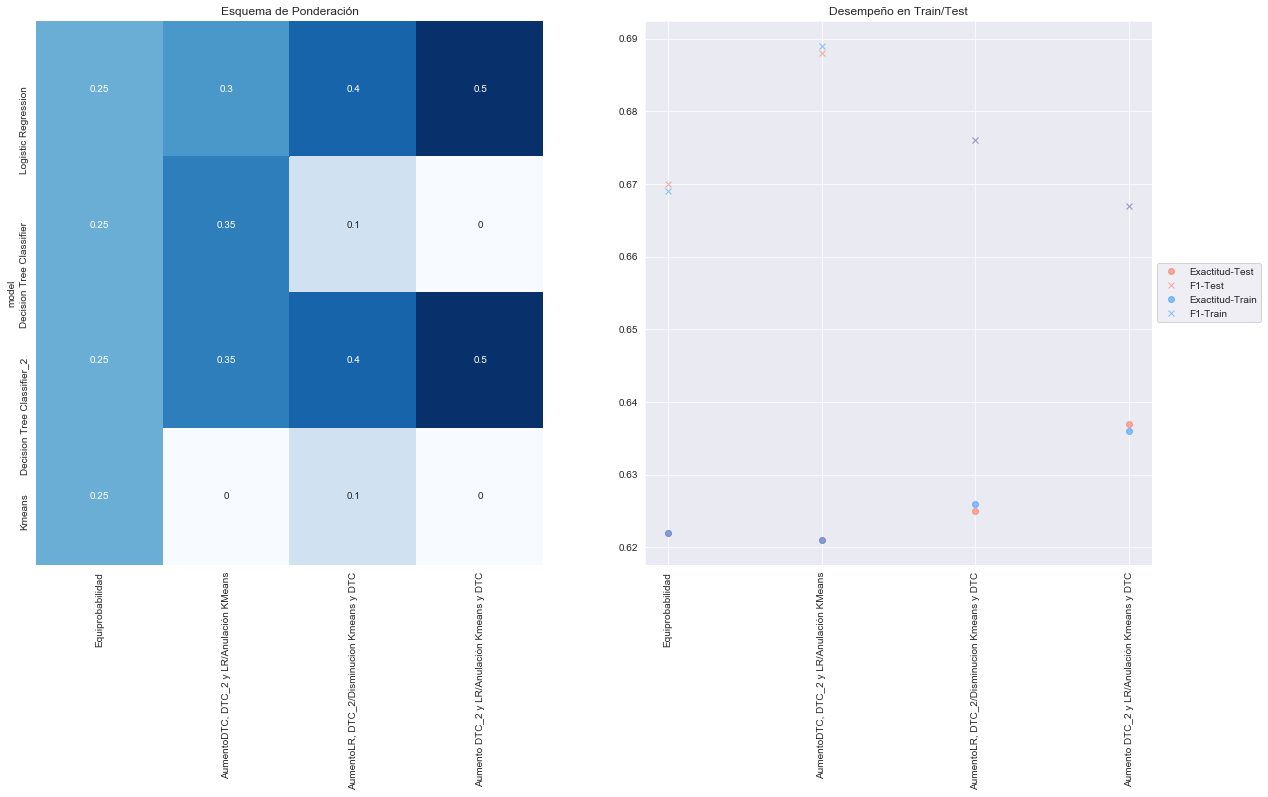

In [ ]:
# implementamos la evaluación del modelo con la función auxiliar
plt.figure(figsize=(20, 10))
weighting_schedule(voting_classifier, X_train, X_test, y_train, y_test,weights_hyperparams)

- Los valores entre las 4 estrategias de ponderación son relativamente similares, la estrategia de ponderación equiprobable, donde todos los modelos tienen el mismo peso, presenta un valor de exactitud  de 0.62, al respecto la mejor estrategia es incrementar los modelos de regresión logística y el árbol de clasificación_2, puesto que mejoran a 0.64, sin embargo los valores de sensibilidad siguen exhibiendo patrones algo dispersos. 


- Para mejorar los valores se pueden probar con otros modelos de clasificación, a continuación se enuncia una propuesta, que necesita mayor capacidad de procesamiento para corroborarse, puesto que se intentó correr y en 12 hrs de procesamiento continuo aún no había respuesta, a eso se le puede sumar que los paramétros de los modelos se pueden intentar optimizar con validaciones cruzadas y gridsearch.  

### Refactorización del Cómite con otros modelos de clasificación 

```python

# definimos el comité de clasificadores en una lista de tuplas



from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


estimators = [
('Logistic Regression',LogisticRegression(random_state=1986)),
('Random Forest',RandomForestClassifier(n_jobs=-1, random_state=1986, max_features='log2', n_estimators=50 )),
('Decision Tree Classifier_2', DecisionTreeClassifier(max_depth=15,random_state=1986)),
('Support Vector Classifier', SVC(kernel='linear',random_state=1986)),
('Extra Trees Classifier', ExtraTreesClassifier(n_jobs=-1, n_estimators=50,random_state=1986)),
('AdaBoost', AdaBoostClassifier(learning_rate=0.1, n_estimators=10,random_state=1986)),
('GradientBoost', GradientBoostingClassifier(learning_rate=0.1, n_estimators=10,random_state=1986)),
]

# Iteración de la función de reportes de clasificación con gráficos

plt.figure(figsize=(10, 10))
for index, value in enumerate(estimators):
    plt.subplot(3, 2, index + 1)
    
    plt.title(value[0])
    class_pred = value[1].fit(X_train, y_train).predict(X_test)
    plot_classification_report(y_test, class_pred)
    plt.xlim((0.1, 1.0))
    if (index + 1) % 2 == 0:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    
    
# Instaciación del cómite
voting_classifier = VotingClassifier(estimators).fit(X_train, y_train)

# Reporte del cómite 

plot_classification_report(y_test,voting_classifier.fit(X_train,y_train).predict(X_test))
plt.xlim((0.4, 1.0))
plt.title('Voting Classifier');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

```